#  Graph Basics

In [1]:
using PyPlot  # Packages used

## Graphs

A *graph* is a set of objects, represented as *vertices*, which may be connected (or related)
to other vertices through *edges*. In a *directed graph*, there connections are ordered
(that is, a vertex can be connected to another vertex, but not the opposite). In *undirected graphs*,
all edges are simply seen as a connected between the two vertices.

![Directed_acyclic_graph](directed_acyclic_graph.png "Directed graph")

There are many ways to represent a graph, and here we will use an *adjancency list*. The
vertices will be numbered $1,2,\ldots$ and represented in an array. Each vertex contains
an integer arrays, which lists their "neighbors" - that is, whether the two vertices have
a (directed) edge between them. For undirected graphs, we simply ensure that the edge
appears in both vertices neighbor lists.

To begin with, we define a new type to represent a vertex. The most important field is
`neighbors`, which is a vector of integers. We also include a `coordinates` field which
is optional, but useful for plotting the graph. The `Base.show` function is overloaded
to make the screen output of a vertex look good.

In [2]:
struct Vertex
    neighbors::Vector{Int}       # Indices of neighbors of this Vertex 
    coordinates::Vector{Float64} # 2D coordinates of this Vertex - only for plotting
    Vertex(neighbors; coordinates=[0,0]) = new(neighbors, coordinates)
end

function Base.show(io::IO, v::Vertex)
    print(io, "Neighbors = ", v.neighbors)
end

The entire graph can not be represented as a simple list of `Vertex` elements. Again we implement
a simple custom `Base.show` function for viewing the graph.

In [3]:
struct Graph
    vertices::Vector{Vertex}
end

function Base.show(io::IO, g::Graph)
    for i = 1:length(g.vertices)
        println(io, "Vertex $i, ", g.vertices[i])
    end
end

As an example, the code below creates a graph with 4 vertices, connected as follows:

```
  Vertex 1 -> Vertex 4
  Vertex 2 -> Vertices 1,4
  Vertex 3 -> No vertices
  Vertex 4 -> Vertex 2
```

We also include some $x,y$ coordinates for plotting later.

In [4]:
v1 = Vertex([4], coordinates=[1,0.5])
v2 = Vertex([1,4], coordinates=[0,2])
v3 = Vertex([], coordinates=[-1,1])
v4 = Vertex([2], coordinates=[2,2])
g = Graph([v1,v2,v3,v4])

Vertex 1, Neighbors = [4]
Vertex 2, Neighbors = [1, 4]
Vertex 3, Neighbors = Int64[]
Vertex 4, Neighbors = [2]


## Plotting a graph

If $x,y$ coordinates are provided for all vertices, we can plot graphs with circles
connected by arrows. The code below is not perfect but should work for many of our
examples. If the items appear in wrong sizes, the `scale` argument can be used to
tweak it.

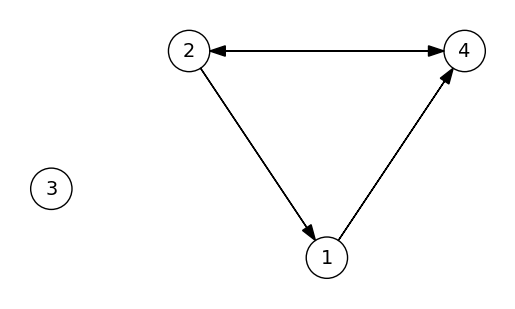

In [5]:
function PyPlot.plot(g::Graph; scale=1.0)
    fig, ax = subplots()
    ax.set_aspect("equal")
    
    xmin = minimum(v.coordinates[1] for v in g.vertices)
    xmax = maximum(v.coordinates[1] for v in g.vertices)
    ymin = minimum(v.coordinates[2] for v in g.vertices)
    ymax = maximum(v.coordinates[2] for v in g.vertices)
    sz = max(xmax-xmin, ymax-ymin)
    cr = scale*0.05sz
    hw = cr/2
    axis([xmin-2cr,xmax+2cr,ymin-2cr,ymax+2cr])
    axis("off")

    for i in 1:length(g.vertices)
        c = g.vertices[i].coordinates
        ax.add_artist(matplotlib.patches.Circle(c, cr, facecolor="none", edgecolor="k"))
        ax.text(c[1], c[2], string(i),
                horizontalalignment="center", verticalalignment="center", fontsize=round(Int, 14*scale))
        for nb in g.vertices[i].neighbors
            cnb = g.vertices[nb].coordinates
            dc = cnb .- c
            L = sqrt(sum(dc.^2))
            c1 = c .+ cr/L * dc
            c2 = cnb .- cr/L * dc
            arrow(c1[1], c1[2], c2[1]-c1[1], c2[2]-c1[2],
                  head_width=hw, length_includes_head=true, facecolor="k")
        end
    end
end
plot(g)

## Creating graphs

We can create graphs using standard Julia array functions. For example, the
functin below creates an undirected *cycle graph* with vertices positioned
along the unit circle:

In [6]:
function circle_graph(nv=8)
    g = Graph([])
    for i = 1:nv
        th = 2π*i/nv
        v = Vertex([mod(i,nv)+1, mod(i-2,nv)+1], coordinates=[cos(th), sin(th)])
        push!(g.vertices, v)
    end
    return g
end

circle_graph (generic function with 2 methods)

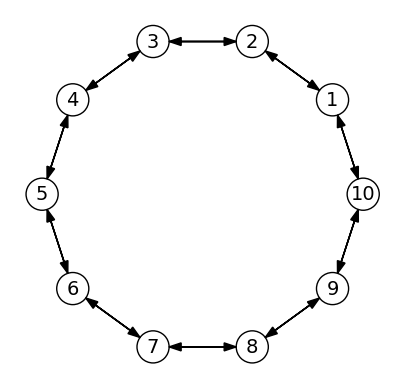

In [7]:
g = circle_graph(10)
plot(g)

The graph can be modified in a number of ways, see examples below:

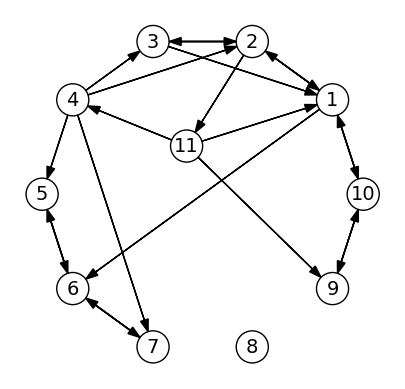

In [8]:
g = circle_graph(10)

# Add edges by growing the neighbors array
push!(g.vertices[1].neighbors, 6);       # Add edge 1->6
append!(g.vertices[4].neighbors, [2,7]); # Add 2 new edges

# Change edges by modifying the neighbors array
g.vertices[3].neighbors[1] = 1           # Change edge, 3->1 instead of 3->4
pop!(g.vertices[5].neighbors)            # Remove edge

# Add a new vertex by growing the vertices array, and if needed
# updating some of the existing neighbors array
# Note that the new vertex should be numbered last, otherwise
# all node numbers must be reordered
newv = Vertex([1,4,9], coordinates=[-.1,.3])
push!(g.vertices, newv)
push!(g.vertices[2].neighbors, 11)

# Deleting a vertex is difficult using adjancency lists
# (unless it is the last vertex), since it requires renumbering
# of the vertices. But as a compromise, we can remove all edges
# to/from a vertex:
resize!(g.vertices[8].neighbors,0)
for v in g.vertices
    filter!(i -> i != 8, v.neighbors)
end

plot(g)